In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.feature_selection import SelectFromModel, mutual_info_regression, f_regression
import numpy as np
import pydotplus 
from IPython.display import Image 
import statsmodels.api as sm
import math
from xgboost.sklearn import XGBRegressor
from sklearn import ensemble
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from dask import dataframe as dd
from dask.multiprocessing import get
from multiprocessing import cpu_count
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_predict
from numba import jit
import geopandas as gpd
from sklearn.ensemble import BaggingClassifier
import random
import xgboost as xgb
from scipy.stats import randint as sp_randint
from shapely.geometry import Point, Polygon
import geojsonio
import requests
import ast
from sklearn import preprocessing
import json
from sklearn import metrics
from functools import partial
from prettytable import PrettyTable
%matplotlib inline

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Question 4 - Part 1

We derive the `tip_percentage` as a percentage of `Total_amount`

In [5]:
green = pd.read_csv("green_taxi_cleaned.csv")
green["lpep_pickup_datetime"] = pd.to_datetime(green["lpep_pickup_datetime"])
green["Lpep_dropoff_datetime"] = pd.to_datetime(green["Lpep_dropoff_datetime"])

In [9]:
green["lpep_pickup_datetime"][green.index[50000]].day

2

Before moving on, let's investigate these two distributions a little - `Fare_amount` and `total_amount`

(array([6.36908765e-03, 7.41356224e-02, 5.02824544e-02, 2.72349773e-02,
        1.58099385e-02, 9.41657821e-03, 5.80411173e-03, 3.83856413e-03,
        2.38824024e-03, 1.47097575e-03, 1.26043405e-03, 6.67430607e-04,
        4.29531893e-04, 2.84164247e-04, 2.60562120e-04, 1.00040834e-04,
        7.54999863e-05, 5.39094040e-05, 4.62655333e-05, 3.24529248e-05,
        3.91580746e-05]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 105]),
 <a list of 21 Patch objects>)

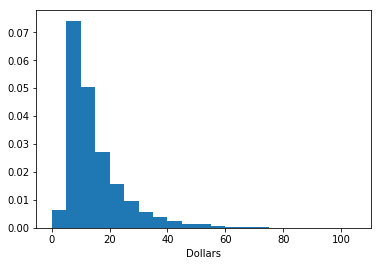

In [80]:
bins = list(range(0, 110, 5))
plt.xlabel("Dollars")
plt.hist(green["Total_amount"], bins=bins, density=True)

(array([1.80588018e-02, 8.31547571e-02, 4.44932713e-02, 2.30111677e-02,
        1.30603200e-02, 7.36621192e-03, 4.23475410e-03, 2.43502718e-03,
        1.46887210e-03, 8.03274766e-04, 1.07393761e-03, 2.50017930e-04,
        1.85267978e-04, 1.16362232e-04, 8.66013850e-05, 5.28188013e-05,
        4.78586601e-05, 3.41847572e-05, 2.70796900e-05, 1.51485395e-05,
        2.42644747e-05]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 105]),
 <a list of 21 Patch objects>)

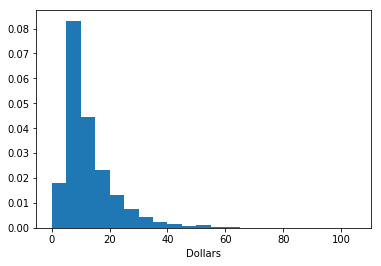

In [81]:
bins = list(range(0, 110, 5))
plt.xlabel("Dollars")
plt.hist(green["Fare_amount"], bins=bins, density=True)

We can see from the graphs that while both of these variables look similar, the `Fare_amount` has a much higher percentage of the data in the first bucket than the `Total_amount`.  

For both the second bucket clearly has the most - between 5 and 10 dollars.  The amounts above 10 dollars appear to  spread out the change in price, for `Total_amount` vs there levels for `Fare_amount`.

We are now in a place to create tip_percentage.

In [6]:
green = green[green["Total_amount"] != 0]

In [7]:
green["tip_percentage"] = (green["Tip_amount"] / green["Total_amount"]) * 100

After obtaining the derived variable I decided to sanity check my work by looking at the min and max.  I found something rather interesting:

In [57]:
green["tip_percentage"].min(), green["tip_percentage"].max()

(0.0, 100.0)

There are some people, admittedly a small percentage, but non the less some people who give 100% of the total amount as a tip.

(array([ 8., 22., 38., 19., 13., 12.,  9.,  2., 14.,  5.,  5.]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]),
 <a list of 11 Patch objects>)

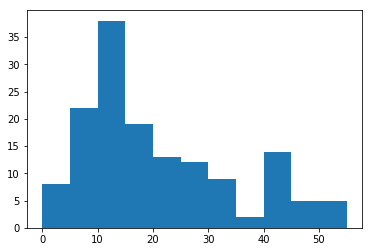

In [59]:
people_who_gave_100 = green[green["tip_percentage"] == 100]["Total_amount"]
bins = list(range(0,60, 5))
plt.hist(people_who_gave_100, bins=bins)

# Question 4 - Part 2

Build a predictive model for tip as a percentage of the total fare.  Use as much of the data as you like.  Provide an estimate of performance using an appropriate sample and show your work.

Because the dataset is so big, I'm going to take a random sample that matches the population parameters as closely as possible.


In [5]:
def ks_selection(sample, df):
    columns = [
        "Passenger_count", 
        "Trip_distance", 
        "Total_amount",
        "Tip_amount"
    ]
    test_results = []
    for column in columns:
        pval = stats.ks_2samp(sample[column], df[column]).pvalue
        test_results.append(pval < 0.05)
    if all(test_results):
        return sample
    else:
        return ''
    

def moment_differencing_selection(sample, df, moment_values):
    columns = [
        "Passenger_count", 
        "Trip_distance", 
        "Total_amount",
        "Tip_amount"
    ]
    tmp = []
    for column in columns:
        first_moment = abs(sample[column].mean() - df[column].mean())
        tmp.append(first_moment)
    for column in columns:
        second_moment = abs(sample[column].std() - df[column].std())
        tmp.append(second_moment)
    moment_values.append(tmp)
    return moment_values
    
    
def generate_representative_sample(df, sample_size=10000, num_iterations=1000):
    """
    This function generates a representative random sample based 
    on specific variables in the data set.
    Variables for consideration:
    * Passenger_count
    * Trip_distance
    * Total_amount
    * Tip_amount
    We attempt two methods:
    - Kolmogorov-Smirnov test as a means of selection
    - moment differencing as criteria for representativeness
    If KS happens to every returns a valid sample,
    that means all the distributions are equal for all variables of consideration.
    If the moment differencing method is used, we search for the sample which minimizes
    difference between the first two moments.
    Notice that we only select on moment differences if ks fails for all generated samples.
    """
    
    possible_samples = []
    moment_values = []
    for _ in range(num_iterations):
        sample = df.sample(sample_size)   
        result = ks_selection(sample, df)
        if result != '':
            return result
        possible_samples.append(sample)
        moment_values = moment_differencing_selection(
             sample, 
             df, 
             moment_values)
            
    min_sum = sum(moment_values[0])
    best_sample = possible_samples[0]
    for index, value in enumerate(moment_values):
        if sum(value) < min_sum:
            min_sum = sum(value)
            best_sample = possible_samples[index]
    return best_sample

    

Above I define a function I will perhaps somewhat boldly define as `generate_representative_sample`.  There are two methods employed here - selection via Kolmogorov-Smirnov which tests the hypothesis - are these distributions the same?  And moment differencing, which tries to recover samples with sample descriptive statistics as close to the population descriptive statistics as possible.

Let's look at the results of our sample.

In [71]:
sample = generate_representative_sample(green, sample_size=50000)

In order to maintain consistency of analysis we save the sample to disk.

In [72]:
sample.to_csv("sample.csv", index=False)

In [8]:
# run this line not the one above, unless you have a lot of time.
sample = pd.read_csv("sample.csv")
sample["lpep_pickup_datetime"] = pd.to_datetime(sample["lpep_pickup_datetime"])
sample["Lpep_dropoff_datetime"] = pd.to_datetime(sample["Lpep_dropoff_datetime"])

# Assessing our sample

First, lets see how good our sample is on `Trip_distance`

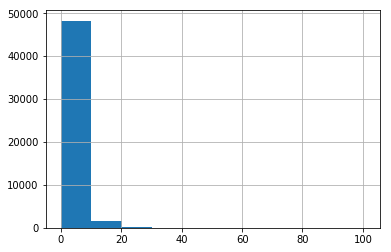

In [73]:
sample["Trip_distance"].hist()

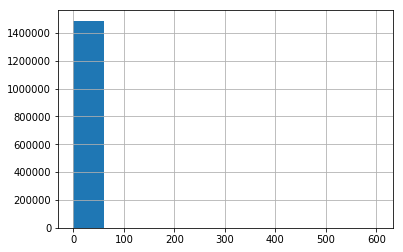

In [74]:
green["Trip_distance"].hist()

Clearly our sample misses some outliers.  Let's see how it does around the center of the data.

(array([4.1806e+04, 6.3960e+03, 1.3220e+03, 3.5500e+02, 7.1000e+01,
        3.1000e+01, 6.0000e+00, 5.0000e+00, 2.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]),
 <a list of 14 Patch objects>)

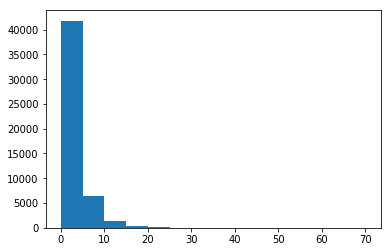

In [75]:
bins = list(range(0, 75, 5))
plt.hist(sample["Trip_distance"], bins=bins)

(array([1.244207e+06, 1.900710e+05, 4.002500e+04, 1.065600e+04,
        2.158000e+03, 7.560000e+02, 2.100000e+02, 8.300000e+01,
        6.800000e+01, 3.300000e+01, 1.700000e+01, 1.500000e+01,
        6.000000e+00, 1.000000e+01]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]),
 <a list of 14 Patch objects>)

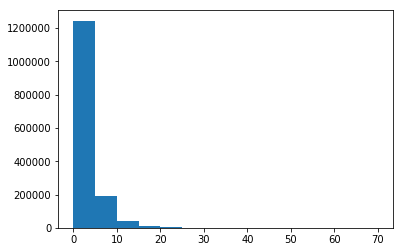

In [76]:
plt.hist(green["Trip_distance"], bins=bins)

These graphs look pretty good!  Let's look at the next variable of interest - `Total_amount`

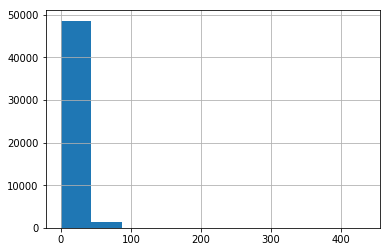

In [77]:
sample["Total_amount"].hist()

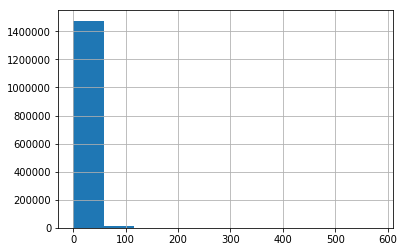

In [78]:
green["Total_amount"].hist()

Again we miss some outliers in our data.  Let's see how we did on approxiate center.

(array([1.5380e+03, 1.8507e+04, 1.2623e+04, 6.8240e+03, 3.9460e+03,
        2.3240e+03, 1.4420e+03, 9.6700e+02, 6.0200e+02, 3.5400e+02,
        3.1900e+02, 1.6000e+02, 1.0800e+02, 7.2000e+01, 6.3000e+01,
        3.3000e+01, 1.9000e+01, 1.4000e+01, 1.9000e+01]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
        85, 90, 95]),
 <a list of 19 Patch objects>)

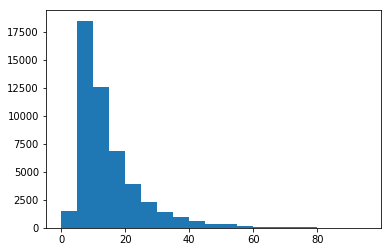

In [79]:
bins = list(range(0, 100, 5))
plt.hist(sample["Total_amount"], bins=bins)

(array([4.33220e+04, 5.52826e+05, 3.74954e+05, 2.03090e+05, 1.17894e+05,
        7.02190e+04, 4.32810e+04, 2.86240e+04, 1.78090e+04, 1.09690e+04,
        9.39900e+03, 4.97700e+03, 3.20300e+03, 2.11900e+03, 1.94300e+03,
        7.46000e+02, 5.63000e+02, 4.02000e+02, 3.59000e+02]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
        85, 90, 95]),
 <a list of 19 Patch objects>)

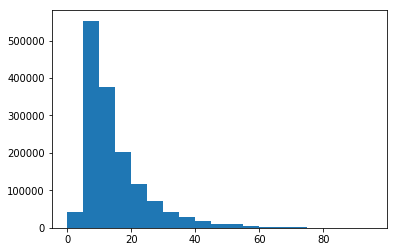

In [80]:
bins = list(range(0, 100, 5))
plt.hist(green["Total_amount"], bins=bins)

These two plots look almost the same!!!  This should give us some confidence in our sample.  Next let's compare `Tip_amount`.

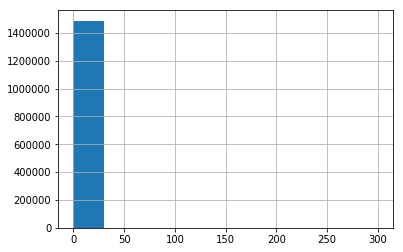

In [81]:
green["Tip_amount"].hist()

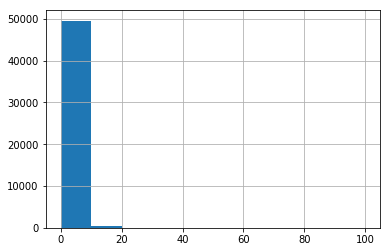

In [82]:
sample["Tip_amount"].hist()

Again we miss some outliers.  Let's so how we do around the center.

(array([4.7141e+04, 2.4260e+03, 3.1100e+02, 4.7000e+01, 3.8000e+01,
        6.0000e+00, 1.0000e+01, 3.0000e+00, 4.0000e+00, 2.0000e+00,
        3.0000e+00]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]),
 <a list of 11 Patch objects>)

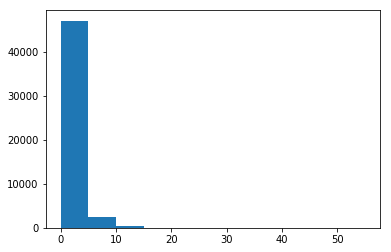

In [83]:
bins = list(range(0, 60, 5))
plt.hist(sample["Tip_amount"], bins=bins)

(array([1.403228e+06, 7.287500e+04, 9.008000e+03, 1.472000e+03,
        6.890000e+02, 2.790000e+02, 2.210000e+02, 8.600000e+01,
        1.270000e+02, 5.300000e+01, 8.800000e+01]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]),
 <a list of 11 Patch objects>)

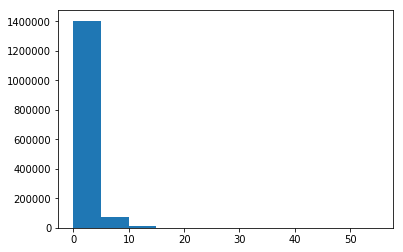

In [84]:
bins = list(range(0, 60, 5))
plt.hist(green["Tip_amount"], bins=bins)

Again we do a decent job around the center of our data.  This gives me confidence that the sample chosen is mostly representative.  But will likely miss some effect from outliers.  But I don't think this is a big deal in the least.

# Feature Engineering

Now that we have a representative sample that we can work with, without the models or feature engineering taking forever, let's dive into the feature engineering piece of this.

Generally speaking, feature engineering is the creation of features from our data.  We can think of these as transformations of our initial variables so we can build a more informed model.  The reason to conduct feature engineering is because our model may not be able to derive good patterns from our initial dataset.  But by increasing the meaningful information from our independent data, we can derive strong models of our dependent variable or variables.

## Planning out our model

Because our dataset is about trips around New York City, there are likely some factors we should focus on when building a model of tip percentage.

First, we need to consider the possibility that no tip is given.  So let's see the percentage of people that even leave a tip first: 

Note - where possible we will use the population distribution.

In [52]:
len(green[green["Tip_amount"] == 0]) / len(green) * 100

59.502961696821146

So, about 60% of those who ride in cabs don't even leave a tip!  This means we will likely need to classify our tip_percentage as leaves tip or doesn't before we can model tip_percentage.  By pushing our data apart into these two classes, we'll be able to deal with these two classes more easily.  For those who don't leave tip, we'll be able to come up with a likely list of factors.  And for those who do leave tip we'll have a similar analysis.

Because of the nice property of `Tip_amount == 0` meaning that no tip was left, we can build a binary classifer with the labels zero and one.  This means when we do prediction we can simply multiply our result multiplied by it's class. 

In [9]:
# Now that we have multiple variables some sense of summary will be helpful
def summary(X_vars, y_var, model, categorical=False):
    """
    Mutual information (MI) [R176] between two random variables is a non-negative value, which measures the dependency between the variables. 
    It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.
    """
    cols = X_vars.columns.tolist()
    # checks to see if the variable is categorical
    if categorical == True:
        lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_vars, y_var)
        model = SelectFromModel(lsvc, prefit=True)
        labels = [cols[x] for x in model.get_support(indices=True) if x]
        X_new = model.transform(X_vars)
        print("Linear SVC Feature reduction")
        print(cols, "->", labels)
    mi = mutual_info_regression(X_vars, y_var)
    #if np.max(mi) != 0:
    #    mi /= np.max(mi)
    f_test, t_test_pvals = f_regression(X_vars, y_var)
    t_test = [math.sqrt(elem) for elem in f_test]
    f_statistic, f_prob = stats.f_oneway(*[np.array(X_vars[column]) for column in X_vars.columns])
    return f_statistic, f_prob, t_test, t_test_pvals, mi, model.coef_
    

In [10]:
def pretty_print_results(X, f_statistic, f_prob, t_test, t_test_pvals, mi, coef):
    cols = X.columns.tolist()
    t_test = list(t_test)
    t_test_pvals = list(t_test_pvals)
    mi = list(mi)
    coef = list(coef)
    tables = []
    if len(X) > 3:
        for index in range(0, len(X), 3):
            if abs(len(X) - index) < 3:
                tmp_col = cols[index:] 
                tmp_t_test = t_test[index:]
                tmp_t_test_pvals = t_test_pvals[index:]
                tmp_mi = mi[index:]
                tmp_coef = coef[index:]
            else:    
                tmp_col = cols[index:index+3] 
                tmp_t_test = t_test[index:index+3]
                tmp_t_test_pvals = t_test_pvals[index:index+3]
                tmp_mi = mi[index:index+3]
                tmp_coef = coef[index:index+3]
            if tmp_col == []:
                break
            tmp_table = PrettyTable(["test_name"] + tmp_col)    
            tmp_table.add_row(["t-test"] + tmp_t_test)
            tmp_table.add_row(["t-test pvals"] + tmp_t_test_pvals)
            tmp_table.add_row(["mutual info"] + tmp_mi)
            tmp_table.add_row(["coefficient"] + tmp_coef)
            tables.append(tmp_table)
            
    else:
        tmp_table = PrettyTable(["test_name"] + col)    
        tmp_table.add_row(["t-test"] + t_test)
        tmp_table.add_row(["t-test pvals"] + t_test_pvals)
        tmp_table.add_row(["mutual info"] + mi)
        tmp_table.add_row(["coefficient"] + coef)
        tables.append(tmp_table)
    print("F-statistic", f_statistic)
    print("F-prob", f_prob)
    for table in tables:
        print(table)

# Considering price

The various aspects of price we will consider include:

* Tip_amount
* Fare_amount
* Total_amount
* Tolls_amount
* improvement_surcharge
* Extra
* MTA_tax

In order to do that, let's check the correlation with `tip_percentage`


In [11]:
columns = [
    "Tip_amount",
    "Fare_amount",
    "Total_amount",
    'Tolls_amount',
    "improvement_surcharge",
    "Extra",
    "MTA_tax"
]
for column in columns:
    print(column)
    print(stats.pearsonr(sample["tip_percentage"], sample[column]))

Tip_amount
(0.7214208879040745, 0.0)
Fare_amount
(0.09257181540035407, 1.3968621330415684e-95)
Total_amount
(0.23828449655020623, 0.0)
Tolls_amount
(0.04312990573999373, 4.99342744531825e-22)
improvement_surcharge
(0.049727980374142534, 9.362278849261666e-29)
Extra
(0.009368229578518043, 0.03618936127895244)
MTA_tax
(0.04974896895113448, 8.881309066586966e-29)


As we can see, there is a strong correlation with:

* Tip_amount
* Total_amount

And somewhat weaker correlations with:

* Fare_amount
* Tolls_amount
* improvement_surcharge
* Extra
* MTA_tax

Let's try regressing `tip_percentage` against all the variables to see what kind of model we statistics we get.  Then we can start to remove features with weaker correlation until we get something promising.

In [12]:
def lin_reg_test_train_split(data, columns):
    X = sample[columns]
    y = sample["tip_percentage"]
    lin_reg = linear_model.LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33)
    lin_reg.fit(X_train, y_train)
    y_pred = lin_reg.predict(X_test)
    print("R^2", metrics.r2_score(y_test, y_pred))
    print("MSE", metrics.mean_squared_error(y_test, y_pred))
    f_statistic, f_prob, t_test, t_test_pvals, mi, coef = summary(X, y, lin_reg)
    pretty_print_results(X, f_statistic, f_prob, t_test, t_test_pvals, mi, coef)
    

In [13]:
columns = ["Tip_amount", 
           "Total_amount",
           "Fare_amount",
           "Tolls_amount",
           "improvement_surcharge",
           "Extra",
           "MTA_tax"]

lin_reg_test_train_split(sample, columns)

R^2 0.5473327877298149
MSE 36.159856182252334
F-statistic 63362.768586448234
F-prob 0.0
+--------------+--------------------+---------------------+------------------------+
|  test_name   |     Tip_amount     |     Total_amount    |      Fare_amount       |
+--------------+--------------------+---------------------+------------------------+
|    t-test    | 232.94168874141045 |  54.861223347053695 |   20.788538977458078   |
| t-test pvals |        0.0         |         0.0         | 1.3968621330690416e-95 |
| mutual info  | 1.6662536368156209 |  1.6070350519700591 |  0.43292027856444104   |
| coefficient  | 4.5776366217282325 | -1.4602115170426688 |   1.2311563990519176   |
+--------------+--------------------+---------------------+------------------------+
+--------------+-----------------------+-----------------------+----------------------+
|  test_name   |      Tolls_amount     | improvement_surcharge |        Extra         |
+--------------+-----------------------+----------------

With an R^2 of only 54% we probably need to do a little feature engineering.  Let's start by removing some of these variables.

Candidates for removal:

* Extra - a miscellaneous surcharge probably doesn't have a ton of predictive power.  Especially given that it has a positive effect on tip_percentage.  This would mean as the price goes up, so does the tip_percentage?  I'd claim that's unlikely, especially given that `Total_amount` has a statistically significant negative coefficient.

* MTA_tax - a tax that is automatically trigged by meters in use.  So this basically gets applied no matter what.  

There are more we can probably remove, but let's see how our model does by removing these variables to start.


In [14]:
columns = ["Tip_amount", 
           "Total_amount",
           "Fare_amount",
           "Tolls_amount",
           "improvement_surcharge"]
lin_reg_test_train_split(sample, columns)

R^2 0.5926837610857153
MSE 31.148878762844422
F-statistic 56765.37927429716
F-prob 0.0
+--------------+--------------------+----------------------+------------------------+
|  test_name   |     Tip_amount     |     Total_amount     |      Fare_amount       |
+--------------+--------------------+----------------------+------------------------+
|    t-test    | 232.94168874141045 |  54.861223347053695  |   20.788538977458078   |
| t-test pvals |        0.0         |         0.0          | 1.3968621330690416e-95 |
| mutual info  | 1.6695348268293282 |  1.6027226273084914  |   0.4364992733341264   |
| coefficient  | 2.9558439208488974 | -0.04209460024379144 |  -0.1802891097544263   |
+--------------+--------------------+----------------------+------------------------+
+--------------+-----------------------+-----------------------+
|  test_name   |      Tolls_amount     | improvement_surcharge |
+--------------+-----------------------+-----------------------+
|    t-test    |    9.65292953

In [29]:
print(stats.pearsonr(sample["Fare_amount"], sample["Total_amount"]))

(0.9763051737316434, 0.0)


Let's do a little more feature reduction.  Next up let's remove:

* Fare_amount - This variable is redundant with respect to `Total_amount`, because `Total_amount` is derived from `Fare_amount` and because the two quantities have a high correlation.

In [15]:
columns = ["Tip_amount", 
           "Total_amount",
           "Tolls_amount",
           "improvement_surcharge"]
lin_reg_test_train_split(sample, columns)

R^2 0.5376792273780095
MSE 36.09981395710843
F-statistic 76866.000823553
F-prob 0.0
+--------------+--------------------+----------------------+-----------------------+
|  test_name   |     Tip_amount     |     Total_amount     |      Tolls_amount     |
+--------------+--------------------+----------------------+-----------------------+
|    t-test    | 232.94168874141045 |  54.861223347053695  |    9.65292953975126   |
| t-test pvals |        0.0         |         0.0          | 4.993427445344896e-22 |
| mutual info  | 1.6686391586447984 |  1.6048409413386544  |  0.025510825556441574 |
| coefficient  | 3.308882618764137  | -0.21935800805581465 |  -0.33816703335840514 |
+--------------+--------------------+----------------------+-----------------------+
+--------------+-----------------------+
|  test_name   | improvement_surcharge |
+--------------+-----------------------+
|    t-test    |   11.133065901745999  |
| t-test pvals | 9.362278842539118e-29 |
| mutual info  | 0.002267867411

In [30]:
print(stats.pearsonr(sample["Tolls_amount"], sample["Total_amount"]))

(0.3600936789643663, 0.0)


As we can see with the unnecessary features removed we have the beginnings of a somewhat reasonable model that is highly interpretable:

* **`Tip_amount` has a statistically significant and positive relationship with `tip_percentage`**.  Thus as tip goes up in absolute terms it also increases in relative terms.


* **`Total_amount` has a statistically significant and negative relationship with `tip_percentage`**.  Thus as the total cost of the ride increases, the tip_percentage falls.


* **`Tolls_amount` has a statistically significant and negative relationship with `tip_percentage`**.  A possible reasoning here is somewhat unclear.  `Total_amount` is only 30% correlated with `Tolls_amount`, which implies most of the relationship between `tip_percentage` and `Tolls_amount` is from having to pay for tolls.  A follow up question worthy of investigation - do toll roads experience more traffic?  If the passenger has to spend longer in the cab, this may explain why tip percentage goes down as `Tolls_amount` increases.


* **`improvement_surcharge` has a statistically significant and positive relationship with `tip_percentage`**.  The `improvement_surcharge` is defined as `$0.30` improvement surcharge assessed on hailed trips at the flag drop.  I'm interpreting this to mean it's for hailed cabs at specific pick up spots.  My guess is this is mostly tourists, using these flag drop spots, because they don't know the city that well.  And my guess is when you are on vacation you are more likely to tip.

# Some distance based features

Some features we will consider including:

* Trip distance
* duration of trip
* average speed travelled
* a mile or less 
* 3.5 or more miles
* between one and 3.5 miles
* during heavy traffic

During heavy traffic may not appear like a distance based feature, but I include it here because duration of the trip will be effected by how much traffic there is on the road.

Thanks to [this analysis from IQuant](http://iquantny.tumblr.com/post/93845043909/quantifying-the-best-and-worst-times-of-day-to-hit) we know that heavy traffic is more or less from 8am to 7pm.  

So let's do some engineering!

In [16]:
@jit
def generate_hour_column(x):
    x["hour"] = x["lpep_pickup_datetime"].hour
    return x

In [17]:
nCores = cpu_count()
sample = dd.from_pandas(sample, npartitions=nCores).map_partitions(
      lambda df : df.apply(generate_hour_column, axis=1)
).compute(get=get)

In [18]:
def distance_feature_engineering(sample):
    ONE_MINUTE = 60
    ONE_HOUR = 60
    boolean_map = {
        True: 1,
        False: 0
    }
    sample = sample[sample["Trip_distance"] != 0]
    sample["duration"] = (sample["Lpep_dropoff_datetime"] - sample["lpep_pickup_datetime"])
    sample["duration"] = np.array([elem.seconds/(ONE_MINUTE*ONE_HOUR) for elem in sample["duration"]])
    sample["ave_speed"] = sample["Trip_distance"] / sample["duration"]  
    
    sample["under_one"] = sample["Trip_distance"] <= 1
    sample["three_and_half_or_more"] = sample["Trip_distance"] >= 3.5
    sample["between_one_and_three"] = (sample["Trip_distance"] > 1) & (sample["Trip_distance"] < 3.5)
    sample["during_heavy_traffic"] = (sample["hour"] >= 7) & (sample["hour"] <= 19)
    
    sample["under_one"] = sample["under_one"].map(boolean_map)
    sample["three_and_half_or_more"] = sample["three_and_half_or_more"].map(boolean_map)
    sample["between_one_and_three"] = sample["between_one_and_three"].map(boolean_map)
    sample["during_heavy_traffic"] = sample["during_heavy_traffic"].map(boolean_map)
    return sample

sample = distance_feature_engineering(sample)
sample = sample.replace([np.inf, -np.inf], np.nan)
sample = sample.dropna()

_Note_: in the above code we lose some entries to the Trip_distance being zero.  Those are likely uninteresting cases in any event.  And should probably be removed prior to sampling.  Time permitting, I will rerun all analysis and remove them during the data cleaning phase in Question 1.

Now that we have more features, let's rerun those models, to see if we have teased out some more signal from our feature engineering.  I'll say upfront, that a higher R^2 doesn't necessarily mean we have.  This is because when you have more independent variables, model performance usually increases, regardless of whether this is picking up on any signal.  So it might be a good idea to try ridge or lasso regression once we get some confirmation that there is at least an artifical improvement.

In [21]:
columns = ["Tip_amount", 
           "Total_amount",
           "Tolls_amount",
           "improvement_surcharge",
           "Trip_distance", 
           "duration", 
           "ave_speed", 
           "under_one",
           "three_and_half_or_more",
           "between_one_and_three",
           "during_heavy_traffic"]


lin_reg_test_train_split(sample, columns)

R^2 0.6118615448807401
MSE 29.62899945495064
F-statistic 1269.4835120388516
F-prob 0.0
+--------------+--------------------+---------------------+-----------------------+
|  test_name   |     Tip_amount     |     Total_amount    |      Tolls_amount     |
+--------------+--------------------+---------------------+-----------------------+
|    t-test    | 237.24522815107647 |  55.57872238635627  |   9.871407366792363   |
| t-test pvals |        0.0         |         0.0         | 5.816451354108861e-23 |
| mutual info  | 1.6817382878161302 |  1.6200070135766538 |  0.03210759092134907  |
| coefficient  | 3.532941997315916  | -0.3465047257433757 |  -0.13017182160822696 |
+--------------+--------------------+---------------------+-----------------------+
+--------------+-----------------------+------------------------+-----------------------+
|  test_name   | improvement_surcharge |     Trip_distance      |        duration       |
+--------------+-----------------------+---------------------

In [49]:
print(stats.pearsonr(sample["duration"], sample["ave_speed"]))
print(stats.pearsonr(sample["Trip_distance"], sample["duration"]))
print(stats.pearsonr(sample["Tolls_amount"], sample["duration"]))

(-0.012234535673855398, 0.006567775047867236)
(0.08603339803980944, 1.0095444124893287e-81)
(0.027381577511693452, 1.1725681340836943e-09)


Our model performance hasn't fallen and clearly many of these features are meaningful both statistically and semantically.  Perhaps in some sense it's interesting that duration and ave_speed are the only strong candidates for removal at this time:

* `duration` has a pvalue well above 0.05 so we fail reject the null hypothesis that there is a statistical relationship between `duration` and `tip_percentage`.

* `ave_speed` does have a statistically significant relationship, or at least the appearance of one.  The way t-test pvalues are calculated is by taking the magnitude of the coefficient over the standard error.  So there are two reasons a variable may appear statistically significant according to the t-test - 

1. the magnitude of the coefficient is small
2. the size of the standard error is big

If the magnitude of the coefficient is extremely small, then a variable may appear statistically significant even when it doesn't explain much of the variability in the dependent variable.  I believe this is the case for `ave_speed`.  So I'm going to remove it as well.


In [23]:
columns = ["Tip_amount", 
           "Total_amount",
           "Tolls_amount",
           "improvement_surcharge",
           "Trip_distance",   
           "under_one",
           "three_and_half_or_more",
           "between_one_and_three",
           "during_heavy_traffic"]
lin_reg_test_train_split(sample, columns)

R^2 0.6389295198343382
MSE 27.55464423869254
F-statistic 73716.1475175166
F-prob 0.0
+--------------+--------------------+---------------------+-----------------------+
|  test_name   |     Tip_amount     |     Total_amount    |      Tolls_amount     |
+--------------+--------------------+---------------------+-----------------------+
|    t-test    | 237.24522815107647 |  55.57872238635627  |   9.871407366792363   |
| t-test pvals |        0.0         |         0.0         | 5.816451354108861e-23 |
| mutual info  | 1.6702568621775828 |  1.6165007582830002 |  0.034840187317414895 |
| coefficient  | 3.3481290984398027 | -0.2859477534510433 |  -0.12124561675651505 |
+--------------+--------------------+---------------------+-----------------------+
+--------------+-----------------------+------------------------+-----------------------+
|  test_name   | improvement_surcharge |     Trip_distance      |       under_one       |
+--------------+-----------------------+-----------------------

Taking a look at our model now, it appears as though `under_one`, `three_and_half_or_more` and `between_one_and_three` are no longer statistically significant.  So let's remove those as well.

In [24]:
columns = ["Tip_amount", 
           "Total_amount",
           "Tolls_amount",
           "improvement_surcharge",
           "Trip_distance",   
           "during_heavy_traffic"]
lin_reg_test_train_split(sample, columns)

R^2 0.5674526769134793
MSE 33.44418251633563
F-statistic 71106.49769337082
F-prob 0.0
+--------------+--------------------+--------------------+-----------------------+
|  test_name   |     Tip_amount     |    Total_amount    |      Tolls_amount     |
+--------------+--------------------+--------------------+-----------------------+
|    t-test    | 237.24522815107647 | 55.57872238635627  |   9.871407366792363   |
| t-test pvals |        0.0         |        0.0         | 5.816451354108861e-23 |
| mutual info  | 1.6733744632844365 | 1.6168142995976815 |  0.03278611758705985  |
| coefficient  | 3.6868407122565756 | -0.356644776219261 |  -0.2413274939241848  |
+--------------+--------------------+--------------------+-----------------------+
+--------------+-----------------------+------------------------+-----------------------+
|  test_name   | improvement_surcharge |     Trip_distance      |  during_heavy_traffic |
+--------------+-----------------------+------------------------+-----

Now that we have a reasonable model with lots of statistically meaningful features.  Let's interpret them a bit more - we won't worry about the variables we've already covered - `Tip_amount`, `Total_amount`, `Tolls_amount`, `improvement_surcharge` except in conjunction with our new features.  Let's dive in:

* **`Trip_distance` is statistically significant with a small but positive coeficient with respect to `tip_percentage`**.  This implies that as distance increases the `tip_percentage` does as well, if only weakly so.  One explaination for this might be that those more likely to have disposable income and therefore take longer rides are more likely to tip?  Or perhaps there is some level of sympathy on the part of the rider, but only weakly so.

* **`during_heavy_traffic` is statistically significant with a small but negative coeficient with respect to `tip_percentage`**.  This implies that as trips tend to take longer, tip gets lower, to some degree. 


# Going non-linear

Now that we have explored some initial features, let's see if we can get the model performance up with some strong modeling techniques!

First we'll consider decision trees.

In [60]:
def test_trip_distance_price_feature_dec_tree(sample):
    X = sample[["Tip_amount", 
                "Total_amount",
                "Tolls_amount",
                "improvement_surcharge",
                "Trip_distance",   
                "during_heavy_traffic"]]
    y = sample["tip_percentage"]
    dec_tree = tree.DecisionTreeRegressor()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33)
    dec_tree.fit(X_train, y_train)
    y_pred = dec_tree.predict(X_test)
    print("MSE", metrics.mean_squared_error(y_test, y_pred))
    num_features = len(X)
    print("Fitting with GridSearch")
    param_grid = {"criterion": ["mse", "friedman_mse"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 10, 20],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }
    
    dec_tree = tree.DecisionTreeRegressor()
    grid_search = GridSearchCV(dec_tree,
                              param_grid=param_grid,
                              cv=3, scoring="neg_mean_squared_error")
    grid_search.fit(X, y)
    grid_scores = grid_search.grid_scores_
    top_scores = sorted(grid_scores,
                       key=lambda t:t[1],
                        reverse=True)[:3]
    for index, score in enumerate(top_scores):
        print("Model Rank", index+1)
        print("Mean validation Score", score.mean_validation_score)
        print("Std of validation score", np.std(score.cv_validation_scores))
        print("Parameters:", score.parameters)
    print("feature importance")
    feature_importance = grid_search.best_estimator_.feature_importances_
    for index, col in enumerate(X.columns):
        print(col, feature_importance[index])
    

test_trip_distance_price_feature_dec_tree(sample)

MSE 0.5262745800892907
Fitting with GridSearch
Model Rank 1
Mean validation Score -0.8944157385303444
Std of validation score 0.2679614835982544
Parameters: {'criterion': 'friedman_mse', 'max_depth': 20, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Model Rank 2
Mean validation Score -0.8948191723000047
Std of validation score 0.26754740690842144
Parameters: {'criterion': 'mse', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Model Rank 3
Mean validation Score -0.8948720610845088
Std of validation score 0.2680903886837044
Parameters: {'criterion': 'friedman_mse', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 10}
feature importance
Tip_amount 0.9501727196451695
Total_amount 0.043547523025142164
Tolls_amount 1.3706905192841828e-07
improvement_surcharge 0.0
Trip_distance 0.006278116163791934
during_heavy_traffic 1.5040968444974757e-06


As you can see here, the decision tree does amazing!  With a mean squared error of less than 1, this is an extremely well fit model of `tip_percentage`.  The grid search gives us a good sense of what parameters to use and the importance of different features for fitting the model.

Clearly `Tip_amount` is the most important feature by a long shot, being responsible for 95% of the fit.  By contrast, the `improvement_surcharge` doesn't fit the model well at all, according to this model.  

Some of this model's performance could be due to overfitting, so we'll regularize with bagging and limiting the max_depth of the tree more heavily.

In [83]:
def test_trip_distance_price_feature_bagged_dec_tree(sample):
    X = sample[["Tip_amount", 
                "Total_amount",
                "Tolls_amount",
                "improvement_surcharge",
                "Trip_distance",   
                "during_heavy_traffic"]]
    y = sample["tip_percentage"]

    params = {"criterion": "friedman_mse",
              "min_samples_split": 2,
              "max_depth": 10,
              "min_samples_leaf": 5,
              "max_leaf_nodes": None,
              }
    
    bagged_dec_tree = ensemble.BaggingRegressor(tree.DecisionTreeRegressor(**params))
    
    y_pred = cross_val_predict(bagged_dec_tree, X, y, cv=5)
    print("MSE", metrics.mean_squared_error(y, y_pred))
    return bagged_dec_tree

bagged = test_trip_distance_price_feature_bagged_dec_tree(sample)

MSE 1.067219494442713


Based on the fact that our mean squared error rose a bit, we can say that there is probably some less overfitting in our model.  Let's see if we can add anymore features that add power to our analysis.  Next we'll consider our last feature set, time based features.

# Some time based features

Some features we will consider are:

* which week
* day of the week
* day of the month
* hour of the day
* during work hours
* before work hours
* after work hours
* Sunday - Wednesday (None drinking days)
* Thursday - Saturday (Drinking days)
* shift of the day - here we assume cab drivers have one of three 8 hour shifts
* shift change - assume not everyone changes shifts at exactly the same time, but more or less folks are shifting over the course of an hour

There is no hard and fast rule of shifts in the world of cab drivers however, [this nytimes article](https://www.nytimes.com/2011/01/12/nyregion/12taxi.html) pegs one of the shift ends at 4pm so I base my shifts around that and assume an 8 hour work day.

In [25]:
def is_sunday_wednesday(x):
    isocal = x.isocalendar()
    if isocal[2] == 7 or isocal[2] <= 3:
        return True
    else:
        return False

    
def shift(x):
    if x.hour >= 8 and x.hour < 16:
        return 1
    elif x.hour >= 16 and x.hour < 24:
        return 2
    else:
        return 3

    
def shift_change(x):
    if x.hour >= 16 and x.hour < 17:
        return True
    elif x.hour >= 23 and x.hour < 24:
        return True
    elif x.hour >= 7 and x.hour < 8:
        return True
    else:
        return False

def before_work(x):
    isocal = x.isocalendar()
    if isocal[2] <= 5 and x.hour <=9 and x.hour > 5:
        return True
    else:
        return False
    

def during_work(x):
    isocal = x.isocalendar()
    if isocal[2] <= 5 and x.hour >9 and x.hour <= 17:
        return True
    else:
        return False

    
def after_work(x):
    isocal = x.isocalendar()
    if isocal[2] <= 5 and x.hour > 17 and x.hour <= 5:
        return True
    else:
        return False

    
def time_feature_engineering(sample):
    boolean_map = {
        True: 1,
        False: 0
    }
    map_week = {
        36:1,
        37: 2,
        38: 3,
        39: 4,
        40: 5
    }
    sample["which_week"] = sample["lpep_pickup_datetime"].apply(lambda x: x.isocalendar()[1])
    sample["day_of_week"] = sample["lpep_pickup_datetime"].apply(lambda x: x.isocalendar()[2])
    sample["before_work"] = sample["lpep_pickup_datetime"].apply(before_work)
    sample["during_work"] = sample["lpep_pickup_datetime"].apply(during_work)
    sample["after_work"] = sample["lpep_pickup_datetime"].apply(after_work)
    sample["sunday_wednesday"] = sample["lpep_pickup_datetime"].apply(is_sunday_wednesday)
    sample["thursday_saturday"] = sample["sunday_wednesday"].apply(lambda x: not x)
    sample["shift"] = sample["lpep_pickup_datetime"].apply(shift)
    sample["shift_change"] = sample["lpep_pickup_datetime"].apply(shift_change)
    
    sample["before_work"] = sample["before_work"].map(boolean_map)
    sample["during_work"] = sample["during_work"].map(boolean_map)
    sample["after_work"] = sample["after_work"].map(boolean_map)
    sample["shift_change"] = sample["shift_change"].map(boolean_map)
    sample["sunday_wednesday"] = sample["sunday_wednesday"].map(boolean_map)
    sample["thursday_saturday"] = sample["thursday_saturday"].map(boolean_map)
    sample["which_week"] = sample["which_week"].map(map_week)
    return sample

sample = time_feature_engineering(sample)

Let's see how our model does on the time based features alone and then see how it does with both distance and time based features.

In [26]:
columns = ["Tip_amount", 
           "Total_amount",
           "Tolls_amount",
           "improvement_surcharge",
           "Trip_distance",   
           "during_heavy_traffic",
           "which_week", 
           "day_of_week",
           "before_work",
           "during_work",
           "after_work",
           "sunday_wednesday",
           "thursday_saturday",
           "shift",
           "shift_change"]
lin_reg_test_train_split(sample, columns)

R^2 0.6309810398071583
MSE 28.405821802564965
F-statistic 73286.25156915063
F-prob 0.0
+--------------+--------------------+----------------------+-----------------------+
|  test_name   |     Tip_amount     |     Total_amount     |      Tolls_amount     |
+--------------+--------------------+----------------------+-----------------------+
|    t-test    | 237.24522815107647 |  55.57872238635627   |   9.871407366792363   |
| t-test pvals |        0.0         |         0.0          | 5.816451354108861e-23 |
| mutual info  | 1.6783481200022692 |  1.6131349321327813  |  0.029381452565634625 |
| coefficient  | 3.374915125073213  | -0.28513104746790074 |  -0.2594603368557238  |
+--------------+--------------------+----------------------+-----------------------+
+--------------+-----------------------+------------------------+-----------------------+
|  test_name   | improvement_surcharge |     Trip_distance      |  during_heavy_traffic |
+--------------+-----------------------+-------------

Right off the bat, we can drop the following features:
    
* after_work
* thursday_saturday
* shift
* day_of_week

For all of them we fail to reject the null hypothesis and therefore they have no statistical significance.  Let's re-run our model without them and see what to do next.

In [27]:
columns = ["Tip_amount", 
           "Total_amount",
           "Tolls_amount",
           "improvement_surcharge",
           "Trip_distance",   
           "during_heavy_traffic",
           "which_week", 
           "before_work",
           "during_work",
           "sunday_wednesday",
           "shift_change"]
lin_reg_test_train_split(sample, columns)

R^2 0.6280801901355569
MSE 28.095634953632892
F-statistic 73276.32158404126
F-prob 0.0
+--------------+--------------------+---------------------+-----------------------+
|  test_name   |     Tip_amount     |     Total_amount    |      Tolls_amount     |
+--------------+--------------------+---------------------+-----------------------+
|    t-test    | 237.24522815107647 |  55.57872238635627  |   9.871407366792363   |
| t-test pvals |        0.0         |         0.0         | 5.816451354108861e-23 |
| mutual info  | 1.6736983586858418 |  1.6201094066123591 |  0.034136671110990946 |
| coefficient  | 3.317977297415738  | -0.2438969991568882 |  -0.08418451479921868 |
+--------------+--------------------+---------------------+-----------------------+
+--------------+-----------------------+------------------------+-----------------------+
|  test_name   | improvement_surcharge |     Trip_distance      |  during_heavy_traffic |
+--------------+-----------------------+---------------------

We can knock out two more variables due to lack of statistical significance:

* sunday_wednesday
* shift_change

Let's rerun again!

In [28]:
columns = ["Tip_amount", 
           "Total_amount",
           "Tolls_amount",
           "improvement_surcharge",
           "Trip_distance",   
           "during_heavy_traffic",
           "which_week", 
           "before_work",
           "during_work"]
lin_reg_test_train_split(sample, columns)

R^2 0.5772812952521145
MSE 32.531216135041205
F-statistic 71831.97426165019
F-prob 0.0
+--------------+--------------------+---------------------+-----------------------+
|  test_name   |     Tip_amount     |     Total_amount    |      Tolls_amount     |
+--------------+--------------------+---------------------+-----------------------+
|    t-test    | 237.24522815107647 |  55.57872238635627  |   9.871407366792363   |
| t-test pvals |        0.0         |         0.0         | 5.816451354108861e-23 |
| mutual info  | 1.6808505755619043 |  1.6154006781221675 |  0.03515762871718575  |
| coefficient  | 3.5548298324010283 | -0.2913713779720275 |  -0.1552704016218744  |
+--------------+--------------------+---------------------+-----------------------+
+--------------+-----------------------+------------------------+-----------------------+
|  test_name   | improvement_surcharge |     Trip_distance      |  during_heavy_traffic |
+--------------+-----------------------+---------------------

Looking at our model now, we see that the coeficients on `which_week` and `before_work` appear quite small.  Given this we remove them for reasons similar to those stated above - t-test's can pass for two reasons, the magnitude of the coeficient being small or the standard error being large.  Here, clearly the former is at work.

In [29]:
columns = ["Tip_amount", 
           "Total_amount",
           "Tolls_amount",
           "improvement_surcharge",
           "Trip_distance",   
           "during_heavy_traffic",
           "during_work"]
lin_reg_test_train_split(sample, columns)

R^2 0.6306072675250743
MSE 28.250301540397952
F-statistic 72472.64619967017
F-prob 0.0
+--------------+--------------------+---------------------+-----------------------+
|  test_name   |     Tip_amount     |     Total_amount    |      Tolls_amount     |
+--------------+--------------------+---------------------+-----------------------+
|    t-test    | 237.24522815107647 |  55.57872238635627  |   9.871407366792363   |
| t-test pvals |        0.0         |         0.0         | 5.816451354108861e-23 |
| mutual info  | 1.6807947464512116 |  1.6174482762418192 |  0.025579619410943444 |
| coefficient  | 3.302165176799936  | -0.2647503263450512 |  -0.2217275284140616  |
+--------------+--------------------+---------------------+-----------------------+
+--------------+-----------------------+------------------------+-----------------------+
|  test_name   | improvement_surcharge |     Trip_distance      |  during_heavy_traffic |
+--------------+-----------------------+---------------------

Now we have a fully specified model!  Including price, distance and time based features!  Let's explain `during_work` our only new feature:

* **`during_work` is statistically significant with a weak negative coeficient**.  I'm not sure why taking a cab during work would contribute negatively to tip.  Let's investigate. 

In [95]:
print(stats.pearsonr(sample["Trip_distance"], sample["during_work"]))
print(stats.pearsonr(sample["Total_amount"], sample["during_work"]))

(-0.029642846537744422, 4.5002017596093634e-11)
(4.6550353646297935e-05, 0.991749104571429)


The above two tests show broadly there isn't much interaction between distance and price based features.  So we have to conclude it a mystery.  

In any event, now that we have a fully specified model, let's try to get our error rate down, while regularizing our model, so as to not overfit.

Next I will try a gradient boosted tree, because those are typically pretty good for regression problems.

In [107]:
def test_distance_time_price_feature_gbr(sample):
    X = sample[["Tip_amount", 
                "Total_amount",
                "Tolls_amount",
                "improvement_surcharge",
                "Trip_distance",   
                "during_heavy_traffic",
                "during_work"]]
    y = sample["tip_percentage"]
    
    param_grid = {"criterion": ["mse", "friedman_mse"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 10, 20],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              "min_impurity_decrease":[0.1, 0.3, 0.5, 0.7]
              }
    
    gbr = ensemble.GradientBoostingRegressor()
    grid_search = GridSearchCV(gbr,
                              param_grid=param_grid,
                              cv=3, scoring="neg_mean_squared_error")
    grid_search.fit(X, y)
    grid_scores = grid_search.grid_scores_
    top_scores = sorted(grid_scores,
                       key=lambda t:t[1],
                        reverse=True)[:3]
    for index, score in enumerate(top_scores):
        print("Model Rank", index+1)
        print("Mean validation Score", score.mean_validation_score)
        print("Std of validation score", np.std(score.cv_validation_scores))
        print("Parameters:", score.parameters)
    print("feature importance")
    feature_importance = grid_search.best_estimator_.feature_importances_
    for index, col in enumerate(X.columns):
        print(col, feature_importance[index])
            
test_distance_time_price_feature_gbr(sample)

In [108]:
def test_distance_time_price_feature_xgbr(sample):
    X = sample[["Tip_amount", 
                "Total_amount",
                "Tolls_amount",
                "improvement_surcharge",
                "Trip_distance",   
                "during_heavy_traffic",
                "during_work"]]
    y = sample["tip_percentage"]
    
    param_grid = {"criterion": ["mse", "friedman_mse"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 10, 20],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              "min_impurity_decrease":[0.1, 0.3, 0.5, 0.7]
              }
    xgb1 = XGBRegressor()
    parameters = {'objective':['reg:linear'],
                  'learning_rate': [.03, 0.05], 
                  'max_depth': [5, 10, 15],
                  'min_child_weight': [5, 10, 15],
                  'silent': [1],
                  'subsample': [0.3, 0.5],
                  'colsample_bytree': [0.3, 0.5],
                  'colsample_bylevel': [0.3, 0.5],
                  'reg_lambda':[0.5, 1, 5],
                  'n_estimators': [50, 100, 500]}

    grid_search = GridSearchCV(xgb1,
                            parameters,
                            cv = 2,
                            n_jobs = 5,
                            verbose=True,
                            scoring="neg_mean_squared_error")

    grid_search.fit(X, y)
    grid_scores = grid_search.grid_scores_
    top_scores = sorted(grid_scores,
                       key=lambda t:t[1],
                        reverse=True)[:3]
    for index, score in enumerate(top_scores):
        print("Model Rank", index+1)
        print("Mean validation Score", score.mean_validation_score)
        print("Std of validation score", np.std(score.cv_validation_scores))
        print("Parameters:", score.parameters)
    #print("feature importance")
    #feature_importance = grid_search.best_estimator_.feature_importances_
    #for index, col in enumerate(X.columns):
    #    print(col, feature_importance[index])


#test_distance_time_price_feature_xgbr(sample)

I encountered some very strange bug with jupyter notebooks that wouldn't let me run xgboost, so I'm going to past the output below.  The output is the same as the code in the cell directly above, it lives in the script `trying_xgboost.py` and can be run with `python trying_xgboost.py`.  Here is the output:

```
Model Rank 1
Mean validation Score -1.1583046129491124
Std of validation score 0.12531750264735186
Parameters: {'colsample_bylevel': 0.3, 'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 15, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'reg:linear', 'reg_lambda': 0.5, 'silent': 1, 'subsample': 0.5}
Model Rank 2
Mean validation Score -1.1583046129491124
Std of validation score 0.12531750264735186
Parameters: {'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 15, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'reg:linear', 'reg_lambda': 0.5, 'silent': 1, 'subsample': 0.5}
Model Rank 3
Mean validation Score -1.2027621274447884
Std of validation score 0.06019841945548143
Parameters: {'colsample_bylevel': 0.3, 'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'reg:linear', 'reg_lambda': 0.5, 'silent': 1, 'subsample': 0.5}
```


As you can see xgboost gets an extremely high score.  We probably won't be able to do a better job.  And given how many regularization parameters we set, we are probably only overfitting by a little.

Just to be specific here's how regularization works in xgboost:

* By adding randomness:
  * colsample_bytree: This is the percentage of randomly selected columns to split on for each level of the tree.
  * colsample_bylevel: This is the percentage of randomly selected columns for each tree to train on.
  * subsample: This subsample the data at the given ratio.  The smaller the ratio the few trees are grown.
* By some given rate:
  * reg_lambda: this is the L2 regularization rate, which penalizes the model based on output using the L2 norm.
  * learning rate: this is step size shrinkage parameter.  After each boosting step, we can get the new feature weights and then shrink the feature rates, at the learning rate.  
* By tree statistics:
    * max_depth: this puts a maximum on how deep the tree can get.  The fewer the splits the tree can make, the less chance it can overfit the data.


# Classification - Bonus task

Now that we know with some level of certainty we can fit a model, let's see if we can answer a bonus question - can we figure out whether or not riders will leave any tip?

This is prime for classification!  Let's dive right in.

# Dealing with class imbalance

One of the easiest ways to deal with class imbalance is to simply upsample our miniority class.  Since our data is a sample we can simply draw on our population to do this.

In [43]:
print("cases where no tip left", len(sample[sample["tip_percentage"] == 0]))
print("cases where tip was left", len(sample[sample["tip_percentage"] != 0]))
print("no tip percentage:", len(sample[sample["tip_percentage"] == 0])/ len(sample))
print("no tip percentage:", len(sample[sample["tip_percentage"] != 0])/ len(sample))

cases where no tip left 29111
cases where tip was left 20247
no tip percentage: 0.5897929413671542
no tip percentage: 0.41020705863284573


To make these classes even simply need to add 29111 - 20247 = 8864 cases when a tip was left.  One initial problem we may face is whether or not we get unique new data, in lieu of using a unique ID we can use pickup and dropoff to verify that none of our new samples are already in our sample. 

In [33]:
def rebalance_classes(sample, samples_needed=0):
    initial_size = len(sample)
    while True:
        tip = green[green["tip_percentage"] != 0]
        tip_sample = tip.sample(samples_needed)
        tip_sample.isin(sample)
        start_index = max(sample.index)+1
        end_index = start_index + len(tip_sample)
        tip_sample.index = list(range(start_index, end_index))
        sample = sample.append(tip_sample)
        if len(sample) - initial_size == samples_needed:
            break
    return sample
samples_needed = abs(len(sample[sample["tip_percentage"] == 0]) - len(sample[sample["tip_percentage"] != 0]))
sample = rebalance_classes(sample, samples_needed=samples_needed)

Once this completes you will need to rerun the feature engineering:

In [30]:
nCores = cpu_count()
sample = dd.from_pandas(sample, npartitions=nCores).map_partitions(
      lambda df : df.apply(generate_hour_column, axis=1)
).compute(get=get)

sample = distance_feature_engineering(sample)
sample = sample.replace([np.inf, -np.inf], np.nan)
sample = sample.dropna()
sample = time_feature_engineering(sample)

In [31]:
nCores = cpu_count()
green = dd.from_pandas(green, npartitions=nCores).map_partitions(
      lambda df : df.apply(generate_hour_column, axis=1)
).compute(get=get)

green = distance_feature_engineering(green)
sample = sample.replace([np.inf, -np.inf], np.nan)
sample = sample.dropna()
green = time_feature_engineering(green)

In [34]:
len(sample[sample["tip_percentage"] == 0]), len(sample[sample["tip_percentage"] != 0])

(29108, 29108)

Now that our samples are more balanced, let's try running the classifier.

In [35]:
sample.isnull().sum()

VendorID                  0
lpep_pickup_datetime      0
Lpep_dropoff_datetime     0
Store_and_fwd_flag        0
RateCodeID                0
Pickup_longitude          0
Pickup_latitude           0
Dropoff_longitude         0
Dropoff_latitude          0
Passenger_count           0
Trip_distance             0
Fare_amount               0
Extra                     0
MTA_tax                   0
Tip_amount                0
Tolls_amount              0
improvement_surcharge     0
Total_amount              0
Payment_type              0
Trip_type                 0
tip_percentage            0
hour                      0
duration                  0
ave_speed                 0
under_one                 0
three_and_half_or_more    0
between_one_and_three     0
during_heavy_traffic      0
which_week                0
day_of_week               0
before_work               0
during_work               0
after_work                0
sunday_wednesday          0
thursday_saturday         0
shift               

Note we'll need to remove `tip_amount` because there is a 100% correlation between `tip_amount == 0` and `tip_percentage == 0` 

In [37]:
def test_time_gbc(sample):
    map_values = {
        False: 0,
        True: 1
    }
    y = sample["tip_percentage"] != 0
    y = y.map(map_values)
    X = sample[["Total_amount",
                "Tolls_amount",
                "improvement_surcharge",
                "Trip_distance",   
                "during_heavy_traffic",
                "during_work"]]
    num_features = len(X)
    params = {"criterion": "friedman_mse",
              "min_samples_split": 10, 
              "max_depth": num_features*3,
              "min_samples_leaf": 5,
              "max_leaf_nodes": None,
              "warm_start": True
              }
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33)
    gbc = ensemble.GradientBoostingClassifier(**params)
    
    gbc.fit(X_train, y_train)
    y_pred = gbc.predict(X_test)
    print()
    print("F1:", metrics.classification_report(y_test, y_pred))
    print("feature importance:")
    feature_importances = gbc.feature_importances_
    for index, column in enumerate(X.columns):
        print(column, feature_importances[index])
    tree_clf = tree.DecisionTreeClassifier()
    tree_model = tree_clf.fit(X_train, y_pred)

    dot_data = tree.export_graphviz(tree_model, out_file=None, 
                             feature_names=X_test.columns,  
                             class_names="tip_percentage",  
                             filled=True, rounded=True,  
                             special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data)  
    picture = Image(graph.create_png()) 
    
test_time_gbc(sample)


F1:              precision    recall  f1-score   support

          0       0.86      0.87      0.87      9607
          1       0.87      0.86      0.86      9605

avg / total       0.86      0.86      0.86     19212

feature importance:
Total_amount 0.3623726849007213
Tolls_amount 0.004323512482101176
improvement_surcharge 0.005175788542680157
Trip_distance 0.536744241004834
during_heavy_traffic 0.05625460769032233
during_work 0.03512916537934109


ValueError: Number of labels=19212 does not match number of samples=39004

Let's try regularizing to see if our fit is to be believed.

In [62]:
def test_time_gbc2(sample):
    map_values = {
        False: 0,
        True: 1
    }
    y = sample["tip_percentage"] != 0
    y = y.map(map_values)
    X = sample[["Total_amount",
                "Tolls_amount",
                "improvement_surcharge",
                "Trip_distance",   
                "during_heavy_traffic",
                "during_work"]]
    num_features = len(X)
    params = {"criterion": "friedman_mse",
              "min_samples_split": 2, 
              "max_depth": 5,
              "min_samples_leaf": 5,
              "max_leaf_nodes": None,
              "warm_start": False
              }
    bagged_gbc = ensemble.BaggingClassifier(ensemble.GradientBoostingClassifier(**params))
    y_pred = cross_val_predict(bagged_gbc, X, y, cv=10)
    print()
    print("F1:", metrics.classification_report(y, y_pred))

        
test_time_gbc2(sample)


F1:              precision    recall  f1-score   support

          0       0.89      0.85      0.87     29111
          1       0.86      0.89      0.87     29066

avg / total       0.87      0.87      0.87     58177



Despite all the regularization we still get an f1-score around the same level so we can say with some certainty that our classifier does a good job!